## ECE 57000 Project - Initial Code

## Name: Vignesh Sathyaseelan

### Objective: Build an LSTM model to predict the next state in a moecular dynamics simulation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from sklearn.metrics import mean_absolute_error as mae 

import numpy as np
import unidecode
import string
import time
import torch
import pdb

import torch.nn as nn
from torch.autograd import Variable

all_characters = [0,1,2,3,4]

In [2]:
def read_data(filename):
    with open(filename,'r') as f:

        x,y = [],[]
        for i in f:
            x += [float(i.rstrip().split()[0])]
            y += [float(i.rstrip().split()[1])]

    x = np.array(x)
    y = np.array(y)
    
    return x,y


def bin_date(data,bins):
    return np.digitize(data,bins)


def get_random_chunk(data, chunk_len=100):
    
    start_idx = np.random.randint(len(data)-chunk_len)
    
    return (data[start_idx:start_idx + chunk_len],data[start_idx+1:start_idx + chunk_len+1])

def to_tensor(chunk):
    
    n_letters = len(all_characters)
    tensor = torch.zeros(len(chunk), 1, n_letters)

    for count_state, state in enumerate(chunk):
        tensor[count_state][0][state] = 1

    return tensor

def get_one_hot_tensors(input, output):
    return to_tensor(input), to_tensor(output)

No handles with labels found to put in legend.


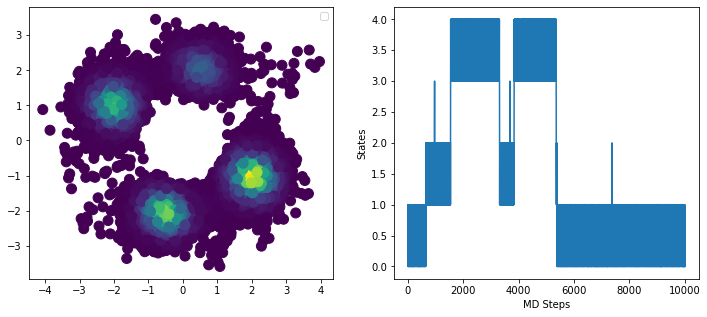

In [13]:
# Calculate the point density

x,y = read_data('md.txt')

bins = [-2,-0.5,0.5,2]
s = bin_date(x,bins)
s = torch.tensor(s)

fig, ax = plt.subplots(1,2,figsize=(12,5))
x,y = x[:100000],y[:100000]
ax[0].scatter(x, y, c=gaussian_kde(np.vstack([x,y]))(np.vstack([x,y])), s=100)
ax[0].legend()
ax[1].plot(np.arange(len(s[:10000])),s[:10000])
ax[1].set_ylabel('States')
ax[1].set_xlabel('MD Steps')
plt.show()

In [4]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1,vocab=5):
        super(RNN, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.vocab = vocab
        
        self.embedding_layer = nn.Embedding(self.vocab, 1)
        self.embedding_linear = nn.Linear(self.vocab, self.input_size)
        self.rnn_cell = nn.GRU(self.input_size, self.hidden_size)
        self.linear = nn.Linear(self.hidden_size,self.output_size) 

    def forward(self, input, hidden):
        
        #input = input.long()
        #input = self.embedding_layer(input)
        input = self.embedding_linear(input)
        
        input = input.reshape(1,1,-1)
        output, hidden = self.rnn_cell(input,hidden)
        output = output.reshape(output.shape[0], -1)
        output = self.linear(output)
        
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, vocab=5, bias=True):
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.vocab = vocab

        self.embedding_layer = nn.Embedding(self.vocab, 1)
        self.embedding_linear = nn.Linear(self.vocab, self.input_size)
        self.xh = nn.Linear(input_size, hidden_size * 4, bias=bias)
        self.hh = nn.Linear(hidden_size, hidden_size * 4, bias=bias)
        self.reset_parameters()
        
        self.s = nn.Sigmoid()
        self.t = nn.Tanh()

    def reset_parameters(self):
        std = 1.0 / np.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, input, hidden=None):
        
        #input = input.long()
        #input = self.embedding_layer(input)
        input = self.embedding_linear(input)
        input = input.reshape(1,1,-1)
        
        # Unpack hidden state and cell state
        hx, cx = hidden

        # Apply linear layers to input and hidden state
        linear = self.xh(input) + self.hh(hx)

        # Get outputs of applying a linear transform for each part of the LSTM
        input_linear, forget_linear, cell_linear, output_linear = linear.reshape(-1).chunk(4)
        
        ######### Your Code Here ###########
        
        # 1. Apply activation functions to get gates and new cell state information
        forget_gate = self.s(forget_linear)
        input_gate = self.s(input_linear)
        output_gate = self.s(output_linear)
        cell_info = self.t(cell_linear)
        
        # 2. Calculate the new cell state (c_new)
        c_new = forget_gate*cx + input_gate*cell_info
        
        # 3. Calculate the new hidden state (h_new)
        h_new = output_gate*self.t(c_new)

        ######### End of your code #########

        # Pack cell state $C_t$ and hidden state $h_t$ into a single hidden state tuple
        output = h_new # For LSTM the output is just the hidden state
        hidden = (h_new, c_new) # Packed h and C
        return output, hidden 

class LSTM_RNN(RNN):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # Replace the gru cell with LSTM cell
        self.rnn_cell = LSTMCell(max_length, hidden_size, max_length)

    def init_hidden(self):
        # LSTM cells need two hidden variables in a tuple of (h_t,C_t)
        return (Variable(torch.zeros(1, 1, self.hidden_size)), Variable(torch.zeros(1, 1, self.hidden_size)))

In [5]:
def train(inp, target, decoder):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0

    input_tensor, target_tensor = get_one_hot_tensors(inp, target)
    
    for c in range(len(inp)):
        output, hidden = decoder(input_tensor[c], hidden)
        loss += criterion(output, torch.argmax(target_tensor[c]).unsqueeze(0))

    loss.backward()
    decoder_optimizer.step()
    return loss.item() / max_length


def evaluate(decoder, prime_str=[1], predict_len=100, temperature=0.8):
    
    hidden = decoder.init_hidden()
    prime_input = to_tensor(prime_str)
    predicted = prime_str
    
    for p in range(len(prime_str) - 1):
        out, hidden = decoder(prime_input[p], hidden)
    
    inp = prime_input[-1]
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        predicted_char = [all_characters[top_i]]
        predicted += predicted_char
        inp = to_tensor(predicted_char)

    return predicted

[(200 6.666666666666667%) 70.13562622070313]
[(400 13.333333333333334%) 46.74338073730469]
[(600 20.0%) 38.297998046875]
[(800 26.666666666666668%) 35.75959167480469]
[(1000 33.33333333333333%) 38.39666748046875]
[(1200 40.0%) 37.07034606933594]
[(1400 46.666666666666664%) 39.562615966796876]
[(1600 53.333333333333336%) 38.306884765625]
[(1800 60.0%) 35.91588439941406]
[(2000 66.66666666666666%) 38.38243103027344]
[(2200 73.33333333333333%) 38.330691528320315]
[(2400 80.0%) 38.66373291015625]
[(2600 86.66666666666667%) 38.580667114257814]
[(2800 93.33333333333333%) 36.82199401855469]
[(3000 100.0%) 36.266204833984375]
______________________________________________________________
[2, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 2, 2, 3, 2, 3, 3, 2, 3, 2, 3, 3, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 2, 3, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2

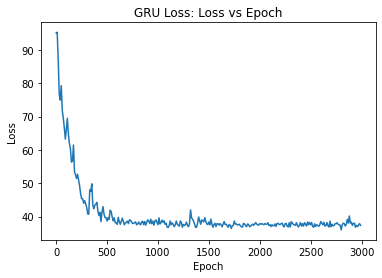

In [6]:
n_epochs = 3000
print_every = 200
plot_every = 10
hidden_size = 300
n_layers = 1
max_length = 5
lr = 0.001

decoder = RNN(max_length, hidden_size, max_length)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(*get_random_chunk(s,hidden_size), decoder)
    loss_avg += loss

    if epoch % print_every == 0:
        print(f"[({epoch} {epoch / n_epochs * 100}%) {loss}]")
        #print(evaluate(decoder, [1], 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

print(f"______________________________________________________________")
print(evaluate(decoder, [2], 200, temperature=0.8))

plt.plot(np.arange(0,n_epochs,plot_every),all_losses)
plt.title("GRU Loss: Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

MAE 0.05815927697302696


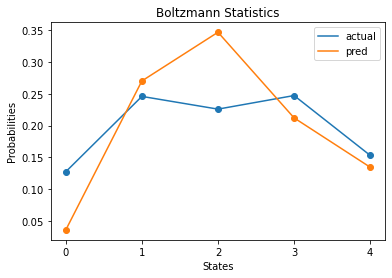

In [7]:
states_count = np.bincount(s)
tot_states = states_count.sum()
p = states_count/tot_states

p_pred = []
for i in range(100):
    s_pred = np.array(evaluate(decoder, [np.random.randint(0,5)], 1000, temperature=1.5))
    states_count_pred = np.bincount(s_pred)
    if len(states_count_pred)<5: 
        #print(s_pred)
        #print(states_count_pred)
        states_count_pred = np.array(list(states_count_pred) + [0]*(5-len(states_count_pred)))
    tot_states_pred = states_count_pred.sum()
    p_pred += [states_count_pred/tot_states_pred]

p_pred = np.array(p_pred).mean(axis=0)

plt.figure()
plt.plot(np.arange(5),p,label='actual')
plt.scatter(np.arange(0,5,1),p)
plt.plot(np.arange(5),p_pred,label='pred')
plt.scatter(np.arange(0,5,1),p_pred)
plt.xticks(np.arange(0,5,1))
plt.ylabel('Probabilities')
plt.xlabel('States')
plt.title('Boltzmann Statistics')
plt.legend()
print(f'MAE {mae(p,p_pred)}')

[(200 6.666666666666667%) 83.53102416992188]
[(400 13.333333333333334%) 67.33365478515626]
[(600 20.0%) 39.63644104003906]
[(800 26.666666666666668%) 38.66749877929688]
[(1000 33.33333333333333%) 41.51655883789063]
[(1200 40.0%) 40.34183349609375]
[(1400 46.666666666666664%) 37.390374755859376]
[(1600 53.333333333333336%) 41.178460693359376]
[(1800 60.0%) 41.05201110839844]
[(2000 66.66666666666666%) 37.054931640625]
[(2200 73.33333333333333%) 37.9676025390625]
[(2400 80.0%) 36.881707763671876]
[(2600 86.66666666666667%) 37.23741149902344]
[(2800 93.33333333333333%) 35.84849548339844]
[(3000 100.0%) 38.603030395507815]
______________________________________________________________
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


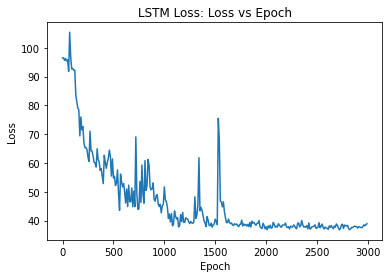

In [8]:
n_epochs = 3000
print_every = 200
plot_every = 10
hidden_size = 300
n_layers = 1
lr = 0.001
max_length = 5

decoder = LSTM_RNN(max_length, hidden_size, max_length)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    
    loss = train(*get_random_chunk(s,hidden_size),decoder)
    loss_avg += loss

    if epoch % print_every == 0:
        print(f"[({epoch} {epoch / n_epochs * 100}%) {loss}]")
        #print(evaluate(decoder, [1], 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0
    
    #if (epoch > 1000) and (loss < 11.5): 
        #print(f"[({epoch} {epoch / n_epochs * 100}%) {loss}]")
        #break

print(f"______________________________________________________________")
print(evaluate(decoder, [1], 100, temperature=0.2))

plt.plot(np.arange(0,epoch-1,plot_every),all_losses)
plt.title("LSTM Loss: Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

MAE 0.02527588136863142


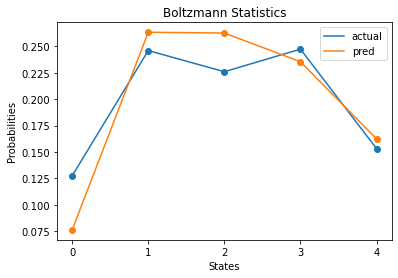

In [9]:
states_count = np.bincount(s)
tot_states = states_count.sum()
p = states_count/tot_states

p_pred = []
for i in range(100):
    s_pred = np.array(evaluate(decoder, [np.random.randint(0,5)], 1000, temperature=1.5))
    states_count_pred = np.bincount(s_pred)
    if len(states_count_pred)<5: 
        #print(s_pred)
        #print(states_count_pred)
        states_count_pred = np.array(list(states_count_pred) + [0]*(5-len(states_count_pred)))
    tot_states_pred = states_count_pred.sum()
    p_pred += [states_count_pred/tot_states_pred]

p_pred = np.array(p_pred).mean(axis=0)

plt.figure()
plt.plot(np.arange(5),p,label='actual')
plt.scatter(np.arange(0,5,1),p)
plt.plot(np.arange(5),p_pred,label='pred')
plt.scatter(np.arange(0,5,1),p_pred)
plt.xticks(np.arange(0,5,1))
plt.ylabel('Probabilities')
plt.xlabel('States')
plt.title('Boltzmann Statistics')
plt.legend()
print(f'MAE {mae(p,p_pred)}')